In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from imblearn import over_sampling
from businessscoring import businessgain

In [2]:
from Feature_Engineering import feature_engineering

In [3]:
features = pd.read_csv('newnewfeatures.csv')

In [4]:
newfeaturenames = ['Procedure_1_Count']*5
newfeaturenames = [newfeaturenames[i-1].replace('1',str(i)) for i in range(1,6)]
for i in range(5):
    features[newfeaturenames[i]] = features[newfeaturenames[i]]/features['Claim_Count'] 
features = features.fillna(0) 

In [5]:
newfeaturenames = ['Diagnosis_1_Count']*9
newfeaturenames = [newfeaturenames[i-1].replace('1',str(i)) for i in range(1,10)]
for i in range(9):
    features[newfeaturenames[i]] = features[newfeaturenames[i]]/features['Claim_Count'] 
features = features.fillna(0)

In [6]:
features.columns
features['Norm_FraudNeighbors'] = features['FraudNeighbor_Count']/(features['NetworkDegree'])  
features = features.fillna(0)
#features['NoPhysicianCount'] = features['NoPhysicianCount']/features['Phys_Count'] 
features['Gender1'] = features['Gender1']/features['Patient_Count']  
features['Race1'] = features['Race1']/features['Patient_Count']
features['Race2'] = features['Race2']/features['Patient_Count']
features['Race3'] = features['Race3']/features['Patient_Count']
conditions=['ChronicCond_Alzheimer_2','ChronicCond_KidneyDisease_2','ChronicCond_Cancer_2',\
            'ChronicCond_ObstrPulmonary_2','ChronicCond_Depression_2','ChronicCond_Diabetes_2',\
            'ChronicCond_IschemicHeart_2','ChronicCond_Osteoporasis_2','ChronicCond_rheumatoidarthritis_2',\
            'ChronicCond_stroke_2']
for condition in conditions:
    features[condition] = features[condition]/features['Patient_Count']


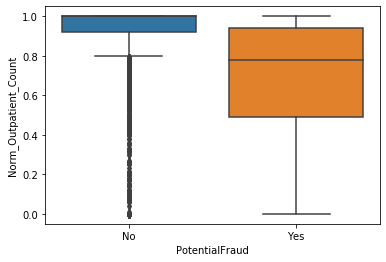

In [7]:
import seaborn as sns
sns.boxplot(x='PotentialFraud',y='Norm_Outpatient_Count',data=features)

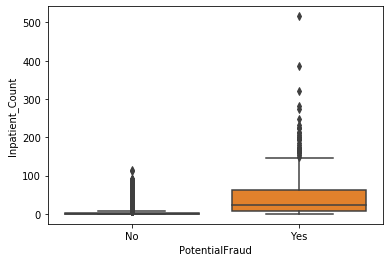

In [8]:
sns.boxplot(x='PotentialFraud',y='Inpatient_Count',data=features)

In [9]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [10]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider','Both_Service','Inpatient','Outpatient','ChronicCond_Alzheimer_1',\
                   'ChronicCond_KidneyDisease_1','ChronicCond_Cancer_1','ChronicCond_ObstrPulmonary_1',\
                  'ChronicCond_Depression_1','ChronicCond_Diabetes_1','ChronicCond_IschemicHeart_1',\
                  'ChronicCond_Osteoporasis_1','ChronicCond_rheumatoidarthritis_1','ChronicCond_stroke_1','Race5','Gender2',\
                   'Outpatient_Count','Inpatient_Count','Norm_Inpatient_Count','Norm_Claim_Count','Norm_Patient_Count',\
                   'DuplicateClaims','isFraudConnected','NoPhysicianCount','FraudNeighbor_Count'], axis=1)
y = features['PotentialFraud'] 

In [11]:
#create seperate dataset with dummy variables to add back after scaling
#non_num = X[['isFraudConnected']]

#drop dummy variables
#X = X.drop(['isFraudConnected'], axis =1)

In [12]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Claim_Count,Norm_Outpatient_Count,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Race1,...,Diagnosis_1_Count,Diagnosis_2_Count,Diagnosis_3_Count,Diagnosis_4_Count,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count,Norm_FraudNeighbors
0,0.470588,-0.017544,-0.077922,-1.538462,0.0,-0.087569,2.881274,1.25,-0.315372,-0.182221,...,-1.754995,-0.088680,-0.166031,0.227765,0.822003,1.238897,0.247736,0.151229,0.012514,0.0
1,2.235294,1.614035,1.311688,-3.615385,0.0,1.250611,3.374576,-1.25,-0.017509,-0.362106,...,0.000000,1.246591,1.559683,1.711314,1.824539,1.969880,2.186381,2.284985,2.460228,0.0
2,1.882353,1.982456,1.532468,0.000000,0.0,-0.093840,-0.006281,-0.25,-0.647981,-0.269370,...,-1.766774,-0.276091,-0.306433,-0.275016,-0.063160,-0.062844,-0.141718,-0.036651,-0.094488,0.0
3,0.000000,8.245614,14.727273,0.000000,0.0,-0.298150,-0.083279,-0.75,-0.007999,-0.552737,...,-0.602573,-0.212924,-0.220899,-0.175546,-0.176231,-0.194756,-0.155007,-0.156494,-0.131321,0.0
4,0.235294,0.578947,0.532468,-0.307692,0.0,-0.376059,0.108817,-1.50,0.300145,-0.320458,...,0.000000,-0.095796,-0.149889,0.072606,0.122703,0.300120,0.280409,0.175034,0.252027,0.2


In [13]:
#add back dummy variables to scaled dataset 
#X_scaled = pd.concat((X_scaled, non_num), axis=1)
X_scaled.head(5)

,Phys_Count,Patient_Count,Claim_Count,Norm_Outpatient_Count,Duplicate_Claims_Percent,AvgClaimDuration,Avg_Cost,Avg_Age,Gender1,Race1,...,Diagnosis_1_Count,Diagnosis_2_Count,Diagnosis_3_Count,Diagnosis_4_Count,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count,Norm_FraudNeighbors
0,0.470588,-0.017544,-0.077922,-1.538462,0.0,-0.087569,2.881274,1.25,-0.315372,-0.182221,...,-1.754995,-0.088680,-0.166031,0.227765,0.822003,1.238897,0.247736,0.151229,0.012514,0.0
1,2.235294,1.614035,1.311688,-3.615385,0.0,1.250611,3.374576,-1.25,-0.017509,-0.362106,...,0.000000,1.246591,1.559683,1.711314,1.824539,1.969880,2.186381,2.284985,2.460228,0.0
2,1.882353,1.982456,1.532468,0.000000,0.0,-0.093840,-0.006281,-0.25,-0.647981,-0.269370,...,-1.766774,-0.276091,-0.306433,-0.275016,-0.063160,-0.062844,-0.141718,-0.036651,-0.094488,0.0
3,0.000000,8.245614,14.727273,0.000000,0.0,-0.298150,-0.083279,-0.75,-0.007999,-0.552737,...,-0.602573,-0.212924,-0.220899,-0.175546,-0.176231,-0.194756,-0.155007,-0.156494,-0.131321,0.0
4,0.235294,0.578947,0.532468,-0.307692,0.0,-0.376059,0.108817,-1.50,0.300145,-0.320458,...,0.000000,-0.095796,-0.149889,0.072606,0.122703,0.300120,0.280409,0.175034,0.252027,0.2


In [14]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

In [16]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

### Examining VIF

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X_train_Bal.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [round(variance_inflation_factor(X_train_Bal.values, i),3)
                          for i in range(len(X_train_Bal.columns))] 
  
print(vif_data)

                              feature     VIF
0                          Phys_Count   3.143
1                       Patient_Count  24.385
2                         Claim_Count  20.609
3               Norm_Outpatient_Count  34.537
4            Duplicate_Claims_Percent   1.096
5                    AvgClaimDuration   3.351
6                            Avg_Cost  11.658
7                             Avg_Age   1.075
8                             Gender1   1.048
9                               Race1   5.444
10                              Race2   4.404
11                              Race3   3.054
12            ChronicCond_Alzheimer_2   1.210
13        ChronicCond_KidneyDisease_2   1.659
14               ChronicCond_Cancer_2   1.096
15       ChronicCond_ObstrPulmonary_2   1.423
16           ChronicCond_Depression_2   1.175
17             ChronicCond_Diabetes_2   1.341
18        ChronicCond_IschemicHeart_2   1.314
19         ChronicCond_Osteoporasis_2   1.075
20  ChronicCond_rheumatoidarthriti

### Examining Correlation Matrix

In [18]:
# Correlation Matrix 
corr = features.corr().abs()
corr.style.background_gradient(cmap='coolwarm')

### Logistic Regression

In [19]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.metrics import make_scorer
plt.style.use('ggplot')

#### SMOTE balanced data

In [20]:
# SMOTE balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_train_Bal, y_train_Bal)
logistic.score(X_test, y_test)
print("SMOTE; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

SMOTE; 
Logistic Regression Baseline recall score:  0.8613861386138614


In [21]:
grid_para_logit = {
    'C': np.linspace(4.0,5.0,20)
}
businessscore = make_scorer(businessgain)
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=businessscore, n_jobs=-1)
%time grid_search_logit.fit(X_train_Bal, y_train_Bal)

CPU times: user 1.98 s, sys: 204 ms, total: 2.18 s
Wall time: 27.1 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([4.        , 4.05263158, 4.10526316, 4.15789474, 4.21052632,
       4.26315789, 4.31578947, 4.36842105, 4.42105263, 4.47368421,
       4.52631579, 4.57894737, 4.63157895, 4.68421053, 4.73684211,
       4.78947368, 4.84210526, 4.89473684, 4.94736842, 5.        ])},
             scoring=make_scorer(businessgain))

In [22]:
#SMOTE
logit_final1 = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final1.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final1.predict(X_test)))
SMOTE_logit = businessgain(y_test,logit_final1.predict(X_test))

{'C': 4.2631578947368425}
Logistic Regression Grid Search train recall score:  0.5932332994090647
Logistic Best Estimator Validation set recall score:  0.8613861386138614
Logistic Best Estimator Validation set business score:  0.536368129735441


#### imblearn balanced dataset

In [23]:
# imblearn balancing
logistic = LogisticRegression(C=0.237, solver = 'liblinear',penalty='l2')
logistic.fit(X_ros, y_ros)
logistic.score(X_test, y_test)
print("Random oversampling; \nLogistic Regression Baseline recall score: ", recall_score(y_test,logistic.predict(X_test)))

Random oversampling; 
Logistic Regression Baseline recall score:  0.8712871287128713


In [24]:
grid_para_logit = {
    'C': np.linspace(0,1.5,20)
}
grid_search_logit = ms.GridSearchCV(logistic, grid_para_logit, cv=s_kf, scoring=businessscore, n_jobs=-1)
%time grid_search_logit.fit(X_ros, y_ros)

CPU times: user 1.32 s, sys: 44.6 ms, total: 1.37 s
Wall time: 10.4 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(C=0.237, solver='liblinear'),
             n_jobs=-1,
             param_grid={'C': array([0.        , 0.07894737, 0.15789474, 0.23684211, 0.31578947,
       0.39473684, 0.47368421, 0.55263158, 0.63157895, 0.71052632,
       0.78947368, 0.86842105, 0.94736842, 1.02631579, 1.10526316,
       1.18421053, 1.26315789, 1.34210526, 1.42105263, 1.5       ])},
             scoring=make_scorer(businessgain))

In [25]:
logit_final = grid_search_logit.best_estimator_
print(grid_search_logit.best_params_)
print("Logistic Regression Grid Search train recall score: ", grid_search_logit.best_score_)
print("Logistic Best Estimator Validation set recall score: ", recall_score(y_test,logit_final.predict(X_test)))
print("Logistic Best Estimator Validation set business score: ", businessgain(y_test,logit_final.predict(X_test)))
imblearn_logit = businessgain(y_test,logit_final.predict(X_test))

{'C': 0.07894736842105263}
Logistic Regression Grid Search train recall score:  0.5494244058665
Logistic Best Estimator Validation set recall score:  0.8712871287128713
Logistic Best Estimator Validation set business score:  0.5460193890304158


#### Comparing SMOTE and imblearn

In [26]:
print('SMOTE logit business score: ', SMOTE_logit, '\nimblearn logit business score: ', imblearn_logit)

SMOTE logit business score:  0.536368129735441 
imblearn logit business score:  0.5460193890304158


#### feature importance for logistic regression

,Feature,Score
4,Duplicate_Claims_Percent,5.543378
26,Procedure_4_Count,1.322663
2,Claim_Count,0.857614
0,Phys_Count,0.540351
6,Avg_Cost,0.290207
22,NetworkDegree,0.204621
31,Diagnosis_4_Count,0.188903
27,Procedure_5_Count,0.184990
5,AvgClaimDuration,0.166766
37,Norm_FraudNeighbors,0.157453


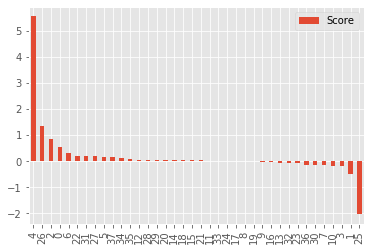

In [27]:
importance = logit_final1.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], v
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Stochastic Gradient Descent Classifier

In [28]:
from sklearn.linear_model import SGDClassifier

#### SMOTE

In [29]:
# SMOTE
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

SMOTE: 
SGD Baseline recall score:  1.0


In [30]:
grid_para_sgd = {
    'max_iter': [1, 10, 100, 1000],
    'alpha': np.linspace(1e-3,5e-3,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=businessscore, n_jobs=-1)
%time grid_search_sgd.fit(X_train_Bal, y_train_Bal)

CPU times: user 4.2 s, sys: 109 ms, total: 4.31 s
Wall time: 25 s


/home/truong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.001     , 0.00113793, 0.00127586, 0.00141379, 0.00155172,
       0.00168966, 0.00182759, 0.00196552, 0.00210345, 0.00224138,
       0.00237931, 0.00251724, 0.00265517, 0.0027931 , 0.00293103,
       0.00306897, 0.0032069 , 0.00334483, 0.00348276, 0.00362069,
       0.00375862, 0.00389655, 0.00403448, 0.00417241, 0.00431034,
       0.00444828, 0.00458621, 0.00472414, 0.00486207, 0.005     ]),
                         'max_iter': [1, 10, 100, 1000]},
             scoring=make_scorer(businessgain))

In [31]:
print("SMOTE: \n")
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final1 = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final1.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final1.predict(X_test)))
SMOTE_sgd = businessgain(y_test,sgd_final1.predict(X_test))

SMOTE: 

SGD Grid Search best params:  {'alpha': 0.001, 'max_iter': 1}
SGD Grid Search Training set recall score:  0.8864734852752983
SGD Best Estimator Validation set recall score:  0.9900990099009901
SGD Best Estimator Validation set business score:  0.5833971117738559


#### imblearn balanced

In [32]:
sgd = SGDClassifier(loss='log', max_iter=1e4, l1_ratio=0, alpha=1e-4, shuffle=False)
sgd.fit(X_ros, y_ros)
print("Imblearn Balanced: \nSGD Baseline recall score: ", recall_score(y_test,sgd.predict(X_test)))

Imblearn Balanced: 
SGD Baseline recall score:  1.0


In [33]:
grid_para_sgd = {
    'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
    'alpha': np.linspace(5e-4,1e-4,30)
}
grid_search_sgd = ms.GridSearchCV(sgd, grid_para_sgd, cv=s_kf, scoring=businessscore, n_jobs=-1)
%time grid_search_sgd.fit(X_ros, y_ros)

CPU times: user 8.2 s, sys: 249 ms, total: 8.45 s
Wall time: 32.7 s


/home/truong/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SGDClassifier(l1_ratio=0, loss='log', max_iter=10000.0,
                                     shuffle=False),
             n_jobs=-1,
             param_grid={'alpha': array([0.0005    , 0.00048621, 0.00047241, 0.00045862, 0.00044483,
       0.00043103, 0.00041724, 0.00040345, 0.00038966, 0.00037586,
       0.00036207, 0.00034828, 0.00033448, 0.00032069, 0.0003069 ,
       0.0002931 , 0.00027931, 0.00026552, 0.00025172, 0.00023793,
       0.00022414, 0.00021034, 0.00019655, 0.00018276, 0.00016897,
       0.00015517, 0.00014138, 0.00012759, 0.00011379, 0.0001    ]),
                         'max_iter': [0.001, 0.01, 0.1, 1, 10, 100, 1000,
                                      10000]},
             scoring=make_scorer(businessgain))

In [34]:
print("SGD Grid Search best params: ", grid_search_sgd.best_params_)
print("SGD Grid Search Training set recall score: ", grid_search_sgd.best_score_)
sgd_final = grid_search_sgd.best_estimator_
print("SGD Best Estimator Validation set recall score: ", recall_score(y_test,sgd_final.predict(X_test)))
print("SGD Best Estimator Validation set business score: ", businessgain(y_test,sgd_final.predict(X_test)))
imblearn_sgd = businessgain(y_test,sgd_final.predict(X_test))

SGD Grid Search best params:  {'alpha': 0.0001, 'max_iter': 100}
SGD Grid Search Training set recall score:  0.9205077792285117
SGD Best Estimator Validation set recall score:  1.0
SGD Best Estimator Validation set business score:  0.48877278361027693


#### Comparing SMOTE with imblearn

In [35]:
print('SMOTE SGD business score: ', SMOTE_sgd, '\nimblearn SGD business score: ', imblearn_sgd)

SMOTE SGD business score:  0.5833971117738559 
imblearn SGD business score:  0.48877278361027693


#### SGD feature Importance

,Feature,Score
2,Claim_Count,2.001226
10,Race2,1.819532
35,Diagnosis_8_Count,1.764429
11,Race3,1.381530
9,Race1,1.271032
0,Phys_Count,1.184453
6,Avg_Cost,1.074490
33,Diagnosis_6_Count,1.018238
37,Norm_FraudNeighbors,0.839863
23,Procedure_1_Count,0.754824


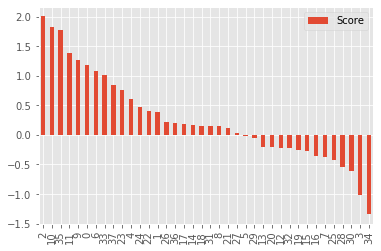

In [36]:
importance = sgd_final.coef_[0]
feature_importance = pd.DataFrame(columns = ('Feature', 'Score'))

# summarize feature importance
for i,v in enumerate(importance):
    feature_importance.loc[i] = X_train_Bal.columns[i], v
    
# plot feature importance
scores = feature_importance.sort_values(by = 'Score', ascending=False)
scores.plot.bar()
scores

### Discriminant Analysis

#### SMOTE

In [37]:
from sklearn import discriminant_analysis

#### Your code here, name your model object LDA
LDA = discriminant_analysis.LinearDiscriminantAnalysis()
LDA.fit(X_train_Bal, y_train_Bal)

LinearDiscriminantAnalysis()

In [38]:
y_predict = LDA.predict(X_test)
print("SMOTE: \nLDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("LDA Baseline validation set business score: ", businessgain(y_test,y_predict))

SMOTE: 
LDA Baseline validation set recall score:  0.8217821782178217
LDA Baseline validation set business score:  0.47838444355881965


In [39]:
QDA = discriminant_analysis.QuadraticDiscriminantAnalysis()
QDA.fit(X_train_Bal, y_train_Bal)
y_predict = QDA.predict(X_test)

print("QDA Baseline validation set recall score: ", recall_score(y_test,y_predict))
print("QDA Baseline validation set business score: ", businessgain(y_test,y_predict))


QDA Baseline validation set recall score:  0.8811881188118812
QDA Baseline validation set business score:  0.4467810968199982


### Non-linear Models


In [237]:
features = pd.read_csv('newnewfeatures.csv')

In [238]:
features.columns

Index(['Provider', 'Phys_Count', 'Patient_Count', 'Norm_Patient_Count',
       'Claim_Count', 'Norm_Claim_Count', 'Service_Type', 'Both_Service',
       'Inpatient', 'Outpatient', 'Inpatient_Count', 'Outpatient_Count',
       'Norm_Inpatient_Count', 'Norm_Outpatient_Count', 'DuplicateClaims',
       'Duplicate_Claims_Percent', 'AvgClaimDuration', 'Avg_Cost', 'Avg_Age',
       'Gender1', 'Gender2', 'Race1', 'Race2', 'Race3', 'Race5',
       'ChronicCond_Alzheimer_1', 'ChronicCond_Alzheimer_2',
       'ChronicCond_KidneyDisease_1', 'ChronicCond_KidneyDisease_2',
       'ChronicCond_Cancer_1', 'ChronicCond_Cancer_2',
       'ChronicCond_ObstrPulmonary_1', 'ChronicCond_ObstrPulmonary_2',
       'ChronicCond_Depression_1', 'ChronicCond_Depression_2',
       'ChronicCond_Diabetes_1', 'ChronicCond_Diabetes_2',
       'ChronicCond_IschemicHeart_1', 'ChronicCond_IschemicHeart_2',
       'ChronicCond_Osteoporasis_1', 'ChronicCond_Osteoporasis_2',
       'ChronicCond_rheumatoidarthritis_1',
     

In [239]:
newfeaturenames = ['Procedure_1_Count']*5
newfeaturenames = [newfeaturenames[i-1].replace('1',str(i)) for i in range(1,6)]
for i in range(5):
    features[newfeaturenames[i]] = features[newfeaturenames[i]]/features['Claim_Count'] 
features = features.fillna(0) 

In [240]:
newfeaturenames = ['Diagnosis_1_Count']*9
newfeaturenames = [newfeaturenames[i-1].replace('1',str(i)) for i in range(1,10)]
for i in range(9):
    features[newfeaturenames[i]] = features[newfeaturenames[i]]/features['Claim_Count'] 
features = features.fillna(0)

In [241]:
features.columns
features['Norm_FraudNeighbors'] = features['FraudNeighbor_Count']/(features['NetworkDegree'])  
features = features.fillna(0)
#features['NoPhysicianCount'] = features['NoPhysicianCount']/features['Phys_Count'] 
features['Gender1'] = features['Gender1']/features['Patient_Count']  
features['Race1'] = features['Race1']/features['Patient_Count']
features['Race2'] = features['Race2']/features['Patient_Count']
features['Race3'] = features['Race3']/features['Patient_Count']
conditions=['ChronicCond_Alzheimer_2','ChronicCond_KidneyDisease_2','ChronicCond_Cancer_2',\
            'ChronicCond_ObstrPulmonary_2','ChronicCond_Depression_2','ChronicCond_Diabetes_2',\
            'ChronicCond_IschemicHeart_2','ChronicCond_Osteoporasis_2','ChronicCond_rheumatoidarthritis_2',\
            'ChronicCond_stroke_2']
for condition in conditions:
    features[condition] = features[condition]/features['Patient_Count']


In [242]:
features['PotentialFraud'] = features['PotentialFraud'].map({'No': 0, 'Yes': 1})
#features.set_index('Provider', inplace=True)

In [243]:
X = features.drop(['PotentialFraud', 'Service_Type','Provider'], axis=1)
y = features['PotentialFraud'] 

In [244]:
#create seperate dataset with dummy variables to add back after scaling
non_num = X[['isFraudConnected','Inpatient','Outpatient','Both_Service']]

#drop dummy variables
X = X.drop(['isFraudConnected','Inpatient','Outpatient','Both_Service'], axis =1)

In [245]:
#scale on the training set 
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=(X.columns), index=X.index)
X_scaled.head()

,Phys_Count,Patient_Count,Norm_Patient_Count,Claim_Count,Norm_Claim_Count,Inpatient_Count,Outpatient_Count,Norm_Inpatient_Count,Norm_Outpatient_Count,DuplicateClaims,...,Diagnosis_1_Count,Diagnosis_2_Count,Diagnosis_3_Count,Diagnosis_4_Count,Diagnosis_5_Count,Diagnosis_6_Count,Diagnosis_7_Count,Diagnosis_8_Count,Diagnosis_9_Count,Norm_FraudNeighbors
0,0.470588,-0.017544,-0.155665,-0.077922,-0.165527,1.0,-0.100000,1.538462,-1.538462,0.0,...,-1.754995,-0.088680,-0.166031,0.227765,0.822003,1.238897,0.247736,0.151229,0.012514,0.0
1,2.235294,1.614035,0.031527,1.311688,0.000000,12.4,0.614286,3.615385,-3.615385,0.0,...,0.000000,1.246591,1.559683,1.711314,1.824539,1.969880,2.186381,2.284985,2.460228,0.0
2,1.882353,1.982456,0.222660,1.532468,0.125855,0.0,1.742857,0.000000,0.000000,0.0,...,-1.766774,-0.276091,-0.306433,-0.275016,-0.063160,-0.062844,-0.141718,-0.036651,-0.094488,0.0
3,0.000000,8.245614,15.763547,14.727273,26.151847,0.0,16.257143,0.000000,0.000000,4.0,...,-0.602573,-0.212924,-0.220899,-0.175546,-0.176231,-0.194756,-0.155007,-0.156494,-0.131321,0.0
4,0.235294,0.578947,0.650246,0.532468,0.574555,0.6,0.600000,0.307692,-0.307692,0.0,...,0.000000,-0.095796,-0.149889,0.072606,0.122703,0.300120,0.280409,0.175034,0.252027,0.2


In [246]:
#add back dummy variables to scaled dataset 
X_scaled = pd.concat((X_scaled, non_num), axis=1)
#X_scaled = X_scaled.drop(['Inpatient','Outpatient','Both_Service','ChronicCond_Alzheimer_1',\
 #                  'ChronicCond_KidneyDisease_1','ChronicCond_Cancer_1','ChronicCond_ObstrPulmonary_1',\
 #                 'ChronicCond_Depression_1','ChronicCond_Diabetes_1','ChronicCond_IschemicHeart_1',\
 #                 'ChronicCond_Osteoporasis_1','ChronicCond_rheumatoidarthritis_1','ChronicCond_stroke_1','Race5','Gender2',\
 #                  'Outpatient_Count'], axis =1)

In [247]:
#use as cv=skf, ensures results are consistent in each partition
s_kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True);
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [248]:
# SMOTE upsampling for all models
oversample = over_sampling.SMOTE()
X_train_Bal, y_train_Bal = oversample.fit_resample(X_train, y_train)

y_train_Bal.value_counts()

1    3923
0    3923
Name: PotentialFraud, dtype: int64

In [249]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X_train, y_train)

### K-Nearest Neighbors

#### SMOTE

In [250]:
knn = KNeighborsClassifier()
knn.fit(X_train_Bal, y_train_Bal)
print("SMOTE: \nKNN Baseline Training Set recall score: ", recall_score(y_train_Bal,knn.predict(X_train_Bal)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

SMOTE: 
KNN Baseline Training Set recall score:  0.9979607443283202
KNN Baseline Validation Set recall score:  0.801980198019802


In [251]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = businessscore)

knn_GS.fit(X_train_Bal, y_train_Bal)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   49.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [252]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_knn.predict(X_train_Bal)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
SMOTE_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 71}
KNN Grid Search Training set Recall score:  0.9459597247004843
KNN Grid Search Validation set Recall score:  0.9504950495049505
KNN Grid Search Validation set business score:  0.6850565816178519


#### imblearn

In [253]:
knn = KNeighborsClassifier()
knn.fit(X_ros, y_ros)
print("imblearn: \nKNN Baseline Training Set recall score: ", recall_score(y_ros,knn.predict(X_ros)))
print("KNN Baseline Validation Set recall score: ", recall_score(y_test,knn.predict(X_test)))

imblearn: 
KNN Baseline Training Set recall score:  1.0
KNN Baseline Validation Set recall score:  0.7425742574257426


In [254]:
# grid search
params = {'n_neighbors': np.arange(0,10)+70}

knn_GS =  GridSearchCV(knn, param_grid = params,
                       cv=s_kf, n_jobs=(-1), verbose = 1,
                       return_train_score = True,
                       scoring = businessscore)

knn_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   50.1s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79])},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [255]:
print("KNN Grid Search Best params: ", knn_GS.best_params_)
best_knn = knn_GS.best_estimator_
print("KNN Grid Search Training set Recall score: ", recall_score(y_ros, best_knn.predict(X_ros)))
print("KNN Grid Search Validation set Recall score: ", recall_score(y_test, best_knn.predict(X_test)))
print("KNN Grid Search Validation set business score: ", businessgain(y_test, best_knn.predict(X_test)))
imblearn_knn = businessgain(y_test, best_knn.predict(X_test))

KNN Grid Search Best params:  {'n_neighbors': 79}
KNN Grid Search Training set Recall score:  0.9026255416772878
KNN Grid Search Validation set Recall score:  0.9405940594059405
KNN Grid Search Validation set business score:  0.682787664797819


#### Comparing SMOTE and imblearn

In [256]:
print('SMOTE KNN business score: ', SMOTE_knn, '\nimblearn KNN business score: ', imblearn_knn)

SMOTE KNN business score:  0.6850565816178519 
imblearn KNN business score:  0.682787664797819


In [257]:
confusion_matrix(y_test, best_knn.predict(X_test))

array([[772, 209],
       [  6,  95]])

### Support Vector Machine

#### SMOTE

In [258]:
svm = SVC(class_weight='balanced')
svm.fit(X_train_Bal, y_train_Bal)

SVC(class_weight='balanced')

In [259]:
# baseline score
svm_train_recall = recall_score(y_train_Bal, svm.predict(X_train_Bal))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('SMOTE: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

SMOTE: 
SVM BaseLine Train Set Recall Score: 0.8725465205200102
SVM BaseLine Validation Set Recall Score: 0.9405940594059405


In [260]:
# grid search 
params = {'C': np.linspace(1,2,10), 
          'kernel': ['rbf'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = businessscore)
svm_GS.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.6s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                         'gamma': ('auto', 'scale'), 'kernel': ['rbf']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [261]:
print("SVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_svm.predict(X_train_Bal)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
SMOTE_svm = businessgain(y_test, best_svm.predict(X_test))

SVM Grid Search Best params:  {'C': 1.1111111111111112, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  0.8692327300535304
SVM Grid Search Validation set Recall score:  0.9504950495049505
Test Set business Score: 0.7247366724206643


#### imblearn

In [262]:
svm = SVC(class_weight='balanced')
svm.fit(X_ros, y_ros)

SVC(class_weight='balanced')

In [263]:
# baseline score
svm_train_recall = recall_score(y_ros, svm.predict(X_ros))
svm_test_recall = recall_score(y_test, svm.predict(X_test))

print('imblearn: \nSVM BaseLine Train Set Recall Score:', svm_train_recall)
print('SVM BaseLine Validation Set Recall Score:', svm_test_recall)

imblearn: 
SVM BaseLine Train Set Recall Score: 0.862605149120571
SVM BaseLine Validation Set Recall Score: 0.9405940594059405


In [264]:
# grid search 
params = {'C': np.logspace(-1,2,10), 
          'kernel': ['rbf','linear'],
          'gamma':('auto', 'scale')}

svm_GS =  GridSearchCV(svm, params, cv=s_kf, n_jobs=(-1), verbose = 1, return_train_score = True, scoring = businessscore)
svm_GS.fit(X_ros, y_ros)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 442.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 641.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': array([  0.1       ,   0.21544347,   0.46415888,   1.        ,
         2.15443469,   4.64158883,  10.        ,  21.5443469 ,
        46.41588834, 100.        ]),
                         'gamma': ('auto', 'scale'),
                         'kernel': ['rbf', 'linear']},
             return_train_score=True, scoring=make_scorer(businessgain),
             verbose=1)

In [265]:
print("imblearn: \nSVM Grid Search Best params: ", svm_GS.best_params_)
best_svm = svm_GS.best_estimator_
print("SVM Grid Search Training set Recall score: ", recall_score(y_ros, best_svm.predict(X_ros)))
print("SVM Grid Search Validation set Recall score: ", recall_score(y_test, best_svm.predict(X_test)))
print('Test Set business Score:', businessgain(y_test, best_svm.predict(X_test)))
imblearn_svm = businessgain(y_test, best_svm.predict(X_test))

imblearn: 
SVM Grid Search Best params:  {'C': 21.54434690031882, 'gamma': 'auto', 'kernel': 'rbf'}
SVM Grid Search Training set Recall score:  1.0
SVM Grid Search Validation set Recall score:  0.2871287128712871
Test Set business Score: -0.5281725760972439


#### Comparing SMOTE and imblearn

In [266]:
print('SMOTE svm business score: ', SMOTE_svm, '\nimblearn svm business score: ', imblearn_svm)

SMOTE svm business score:  0.7247366724206643 
imblearn svm business score:  -0.5281725760972439


In [267]:
#recall = TP / (TP+FN) 
confusion_matrix(y_test, best_svm.predict(X_test))



array([[942,  39],
       [ 72,  29]])

### Random Forest

In [268]:
from sklearn import ensemble
randomForest = ensemble.RandomForestClassifier()

# fit RF model on SMOTE training set
randomForest.set_params(random_state=0)

randomForest.fit(X_train_Bal, y_train_Bal)

# baseline score
print('SMOTE: \nRF BaseLine Train Set Recall Score:', recall_score(y_train_Bal, randomForest.predict(X_train_Bal)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

SMOTE: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.7326732673267327


In [269]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=businessscore, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_train_Bal, y_train_Bal)

CPU times: user 15.6 s, sys: 575 ms, total: 16.2 s
Wall time: 14min 14s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [270]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_train_Bal, best_RF.predict(X_train_Bal)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
SMOTE_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 14, 'n_estimators': 90}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.7821782178217822
RF Grid Search Validation set Business score:  0.49053301089414586


#### imblearn

In [271]:
randomForest.set_params(random_state=0)

randomForest.fit(X_ros, y_ros)

# baseline score
print('imblearn: \nRF BaseLine Train Set Recall Score:', recall_score(y_ros, randomForest.predict(X_ros)))
print('RF BaseLine Validation Set Recall Score:', recall_score(y_test, randomForest.predict(X_test)))

imblearn: 
RF BaseLine Train Set Recall Score: 1.0
RF BaseLine Validation Set Recall Score: 0.5742574257425742


In [272]:
# set the parameter grid
grid_para_forest = {
    'criterion': ['entropy'],
    'max_depth': range(1, 31),
    'n_estimators': range(10, 110, 10)
}

# run the RF classifier through the grid search
grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring=businessscore, cv=s_kf, n_jobs=-1)
%time grid_search_forest.fit(X_ros, y_ros)

CPU times: user 11.8 s, sys: 339 ms, total: 12.2 s
Wall time: 7min 45s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(1, 31),
                         'n_estimators': range(10, 110, 10)},
             scoring=make_scorer(businessgain))

In [273]:
print("RF Grid Search Best params: ", grid_search_forest.best_params_)
best_RF = grid_search_forest.best_estimator_
print("RF Grid Search Training set Recall score: ", recall_score(y_ros, best_RF.predict(X_ros)))
print("RF Grid Search Validation set Recall score: ", recall_score(y_test, best_RF.predict(X_test)))
print("RF Grid Search Validation set Business score: ", businessgain(y_test,best_RF.predict(X_test)))
imblearn_rf = businessgain(y_test,best_RF.predict(X_test))

RF Grid Search Best params:  {'criterion': 'entropy', 'max_depth': 24, 'n_estimators': 20}
RF Grid Search Training set Recall score:  1.0
RF Grid Search Validation set Recall score:  0.6039603960396039
RF Grid Search Validation set Business score:  0.142402502614099


#### comparing SMOTE and imblearn

In [274]:
print('SMOTE rf business score: ', SMOTE_rf, '\nimblearn rf business score: ', imblearn_rf)

SMOTE rf business score:  0.49053301089414586 
imblearn rf business score:  0.142402502614099


### XG BOOST 

In [275]:
from xgboost import XGBClassifier

#SMOTE
xgb = XGBClassifier(random_state=0)
xgb.fit(X_train_Bal, y_train_Bal)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [276]:
print('SMOTE: \nXGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

SMOTE: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.6237623762376238


In [277]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': np.arange(start=600, stop=750, step=10),
                 'learning_rate': [1e-4,1e-3,5],
                 'n_estimators':  np.arange(start=10, stop=15, step=1),
                 'max_depth': np.arange(start=10, stop=15, step=1),
                 'subsample': [0.9]
                 } 

In [278]:
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=businessscore, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_train_Bal, y_train_Bal)

CPU times: user 54.9 s, sys: 1.64 s, total: 56.6 s
Wall time: 24min 9s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
                                     verbosity=None),
             n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 5],
                         'max

In [279]:
grid_search_xgb.best_params_

{'learning_rate': 0.001,
 'max_depth': 13,
 'n_estimators': 14,
 'scale_pos_weight': 600,
 'subsample': 0.9}

In [280]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_train_Bal, best_xgb.predict(X_train_Bal)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
SMOTE_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9801980198019802
XGB BaseLine Validation Set business Score: 0.47039305782969504


#### imblearn

In [281]:
xgb = XGBClassifier(random_state=0)
xgb.fit(X_ros, y_ros)
print('imblearn: \nXGB BaseLine Train Set Recall Score:', recall_score(y_ros, xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, xgb.predict(X_test)))

imblearn: 
XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.6336633663366337


In [282]:
# parameter tuning
grid_para_xgb = {'scale_pos_weight': [400,500,600],
                 'learning_rate': [0.001, 0.010, 0.1],
                 'n_estimators': [2,5,10] ,
                 'max_depth': [1,3,10],
                 'subsample': [0.9]
                 }
grid_search_xgb = GridSearchCV(xgb, grid_para_xgb, scoring=businessscore, cv=s_kf, n_jobs=-1)
%time grid_search_xgb.fit(X_ros, y_ros)

CPU times: user 6.54 s, sys: 261 ms, total: 6.8 s
Wall time: 25.5 s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_...
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_metho

In [283]:
best_xgb = grid_search_xgb.best_estimator_
print('XGB BaseLine Train Set Recall Score:', recall_score(y_ros, best_xgb.predict(X_ros)))
print('XGB BaseLine Validation Set Recall Score:', recall_score(y_test, best_xgb.predict(X_test)))
print('XGB BaseLine Validation Set business Score:', businessgain(y_test, best_xgb.predict(X_test)))
imblearn_xgb = businessgain(y_test, best_xgb.predict(X_test))

XGB BaseLine Train Set Recall Score: 1.0
XGB BaseLine Validation Set Recall Score: 0.9900990099009901
XGB BaseLine Validation Set business Score: 0.5529449490647207


#### comparing SMOTE and imblearn

In [284]:
print('SMOTE xgb business score: ', SMOTE_xgb, '\nimblearn xgb business score: ', imblearn_xgb)

SMOTE xgb business score:  0.47039305782969504 
imblearn xgb business score:  0.5529449490647207


In [285]:
confusion_matrix(y_test, best_xgb.predict(X_test))

array([[519, 462],
       [  1, 100]])